In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import shapely
from tqdm.autonotebook import tqdm
import pandas as pd
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import linregress
from sklearn.model_selection import KFold, RepeatedKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf

from src.processing import gedi_recovery_analysis
from src.constants import WGS84


/tmp/ipykernel_941874/207539965.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [61]:
# Years of interest
years = range(2019, 2021)

# Small sample region of interest
lat = -5.3494
lon = -56.0282
height = 1
width = 1
sample_roi = shapely.geometry.box(lon - width/2, lat - height/2, lon + height/2, lat + width/2)

# Amazon basin shape file
shapefile = "/home/users/ah2174/gedi-biomass-mapping/amazon_border/biome.shp"

sample_roi_series = gpd.GeoSeries([sample_roi], crs=WGS84)
sample_roi_df = gpd.GeoDataFrame({'geometry': [sample_roi]}, crs=WGS84)

with pd.option_context('display.max_colwidth', None):
    print(sample_roi_df)
    print(sample_roi_df.to_wkt().values[0][0])
    print(sample_roi_series.to_wkt().values[0])
    print(*sample_roi_series.bounds.values)


                                                                                                         geometry
0  POLYGON ((-55.52820 -5.84940, -55.52820 -4.84940, -56.52820 -4.84940, -56.52820 -5.84940, -55.52820 -5.84940))
POLYGON ((-55.5282 -5.8494, -55.5282 -4.8494, -56.5282 -4.8494, -56.5282 -5.8494, -55.5282 -5.8494))
POLYGON ((-55.5282 -5.8494, -55.5282 -4.8494, -56.5282 -4.8494, -56.5282 -5.8494, -55.5282 -5.8494))
[-56.5282  -5.8494 -55.5282  -4.8494]


In [77]:
dfs = []
for year in tqdm(years):
    gedi_df = gedi_recovery_analysis.compute_gedi_recovery(sample_roi_series, year)
    dfs.append(gedi_df)

gedi_data = pd.concat(dfs, ignore_index=True)
print(gedi_data)

  0%|          | 0/2 [00:00<?, ?it/s]

2021-11-23 19:34:26,288 INFO: Loading GEDI shots for 2019 [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:64]
2021-11-23 19:34:34,387 DEBUG: Found 180294 shots in 2019 in the specified geometry [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:79]
2021-11-23 19:34:34,388 INFO: Loading JRC data from 1990 to 2019 [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:86]


  0%|          | 0/30 [00:00<?, ?it/s]

2021-11-23 19:34:36,759 INFO: Computing recovery period until year 2019 [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:94]
2021-11-23 19:34:48,834 INFO: Filtering shots [in overlay_gedi_shots_and_recovery_raster at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:32]
2021-11-23 19:34:49,537 INFO: Loading GEDI shots for 2020 [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:64]
2021-11-23 19:34:49,791 DEBUG: Found 1182 shots in 2020 in the specified geometry [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:79]
2021-11-23 19:34:49,792 INFO: Loading JRC data from 1990 to 2020 [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:86]


  0%|          | 0/31 [00:00<?, ?it/s]

2021-11-23 19:34:52,369 INFO: Computing recovery period until year 2020 [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:94]
2021-11-23 19:35:02,530 INFO: Filtering shots [in overlay_gedi_shots_and_recovery_raster at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:32]
2021-11-23 19:35:02,533 WARNING: No shots found overlapping with JRC recovery data in 2020 [in compute_gedi_recovery at /home/users/ah2174/gedi-biomass-mapping/src/processing/gedi_recovery_analysis.py:102]
           shot_number  recovery_period  overlap_quality   rh95
0    20870200100082732             10.0                0  19.88
1    37670000100082866              6.0                1  15.54
2    37670100100081940              6.0                1  15.54
3    27440300100081125              3.0                2  12.66
4    37670100100081925              7.0                1  13.37
..                 ...              ...        

In [78]:
quality_gedi = gedi_data[(gedi_data.overlap_quality != 0) & (gedi_data.recovery_period >= 3) & (gedi_data.recovery_period <= 22)] 
len(quality_gedi)

139

In [80]:
lin_rh95 = linregress(quality_gedi.recovery_period, quality_gedi.rh95)

Text(0.2, 25.2, 'R-value: 0.33\nslope: 0.35 m/yr\nintercept: 11.73 m')

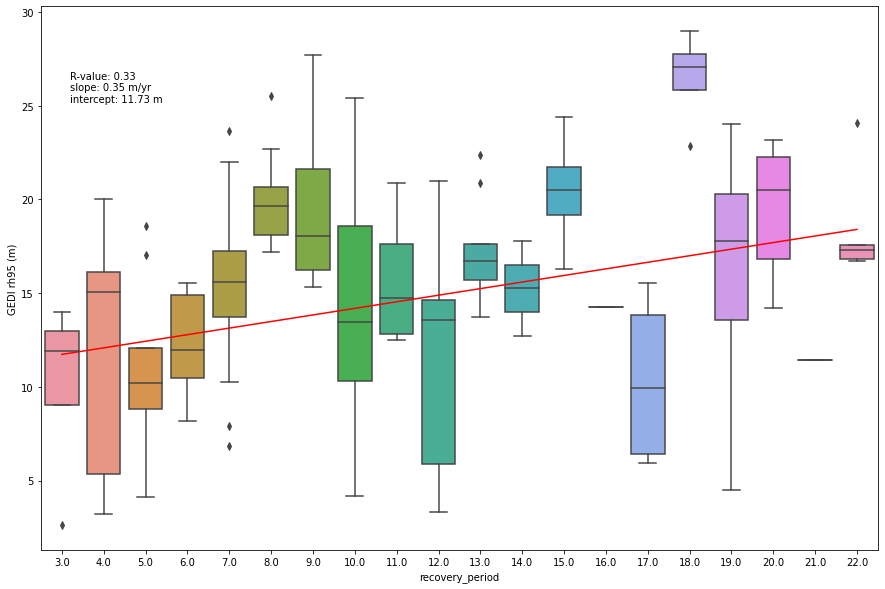

In [81]:
plt.figure(1, (15,10))
ax = sns.boxplot(x="recovery_period", y="rh95", data=quality_gedi)
ax.set_ylabel("GEDI rh95 (m)")
xs = range(0, 20)
ax.plot(xs, lin_rh95.intercept + lin_rh95.slope * xs, 'r')
text_label = (
    "R-value: {0:.2f}\n"
    "slope: {1:.2f} m/yr\n"
    "intercept: {2:.2f} m").format(
        lin_rh95.rvalue, lin_rh95.slope, lin_rh95.intercept)
ax.text(x=0.2, y=25.2, s=text_label)

In [23]:
PAISAGENSLIDAR_PATH = SCRATCH_PATH / "Paisagenslidar" / "processed"
paisagenslidar_surveys = [
    survey
    for survey in PAISAGENSLIDAR_PATH.glob("*/*")
    if (survey / "grid_metrics").exists() and any((survey / "grid_metrics").iterdir())
]


print("Found {} paisangenslidar survey folders".format(
    len(paisagenslidar_surveys)))


Found 104 paisangenslidar survey folders


## Run recovery analysis jobs with

```
$ python3 src/processing/recovery_analysis_jobs.py --dataset=EBA --save_path=$SAVE_PATH --save_every=n --read_checkpoints=True
```
This script checkpoints every n records and can be restarted from saved checkpoint state.
Final results are saved in $SAVE_PATH/all.feather

In [3]:
SAVE_PATH = pathlib.Path("/gws/nopw/j04/forecol/ah2174/biomass_recovery/EBA")
eba_data = pd.read_feather(SAVE_PATH / "all.feather")
eba_data

,recovery_period,overlap_quality,chm_mean,chm_min,chm_max,chm_med,chm_mode,chm_q1,chm_q3,mean,...,x_coord,y_coord,x_index,y_index,acd_longo2016,acd_asner2014,acd_asner2014c,survey,survey_year,crs
0,6,0,12.169973,-0.000,23.982000,12.164000,-0.000000,7.921,16.405001,10.432463,...,622525.0,119775.0,152,64,43.903941,73.941166,49.981701,NP_T-0001,2016,+init=epsg:32620
1,1,0,9.801308,-0.000,16.209999,10.739000,-0.000000,9.047,11.952000,8.219606,...,539225.0,9974375.0,257,80,29.995330,60.171794,37.983337,NP_T-0007,2016,+init=epsg:5355
2,12,0,15.419527,1.402,21.429001,16.025999,14.935000,13.847,17.830000,12.990663,...,539825.0,9974225.0,269,83,66.588436,92.626278,67.477414,NP_T-0007,2016,+init=epsg:5355
3,32,0,14.145414,-0.000,26.229000,14.906000,-0.000000,9.440,19.367001,12.160220,...,557675.0,181525.0,17,34,57.210711,85.325078,60.486370,NP_T-0008,2016,+init=epsg:3180
4,12,0,6.733549,-0.000,23.556999,5.942000,-0.000000,1.417,10.700000,5.148651,...,557375.0,181375.0,11,37,15.491847,42.089994,23.595314,NP_T-0008,2016,+init=epsg:3180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37284,14,0,13.887091,0.002,24.339001,14.097000,15.546000,11.897,16.200001,11.492064,...,785875.0,8689075.0,14,224,55.384673,83.841010,59.088959,NP_T-2005,2017,+init=epsg:5357
37285,6,0,19.361275,2.778,27.580000,20.089001,17.472000,17.226,21.846001,16.134771,...,786075.0,8688825.0,18,229,99.402546,115.040746,90.060915,NP_T-2005,2017,+init=epsg:5357
37286,6,0,17.014893,4.326,29.087000,16.980000,12.033000,13.707,19.820000,14.114271,...,785625.0,8688575.0,9,234,79.186869,101.727877,76.451204,NP_T-2005,2017,+init=epsg:5357
37287,3,0,17.381344,1.228,27.186001,17.871000,16.488001,15.064,20.445999,14.423192,...,785675.0,8688125.0,10,243,82.212993,103.812565,78.545341,NP_T-2005,2017,+init=epsg:5357


In [4]:
quality_eba = eba_data[(eba_data.overlap_quality != 0) & (eba_data.recovery_period >= 3) & (eba_data.recovery_period <= 22)] 
len(quality_eba)

NameError: name 'eba_data' is not defined

In [5]:
lin_chm_med = linregress(quality_eba.recovery_period, quality_eba.chm_med)
lin_acd_longo2016 = linregress(quality_eba.recovery_period, quality_eba.acd_longo2016)
lin_acd_asner2014 = linregress(quality_eba.recovery_period, quality_eba.acd_asner2014)


Text(0.2, 25.2, 'R-score: 0.38\nslope: 0.24 m/yr\nintercept: 6.75 m')

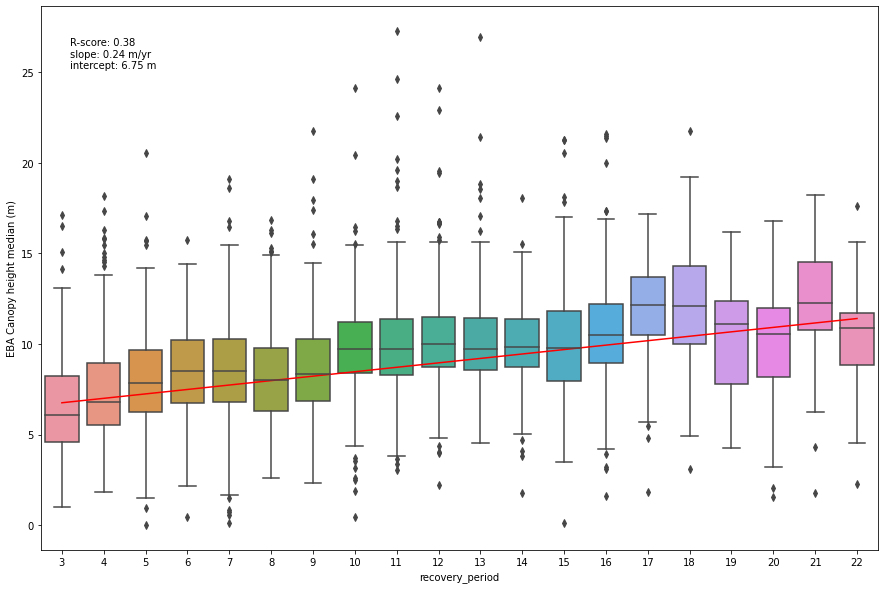

In [12]:
plt.figure(1, (15,10))
ax = sns.boxplot(x="recovery_period", y="chm_med", data=quality_eba)
ax.set_ylabel("EBA Canopy height median (m)")
xs = range(0, 20)
ax.plot(xs, lin_chm_med.intercept + lin_chm_med.slope * xs, 'r')
text_label = (
    "R-score: {0:.2f}\n"
    "slope: {1:.2f} m/yr\n"
    "intercept: {2:.2f} m").format(
        lin_chm_med.rvalue, lin_chm_med.slope, lin_chm_med.intercept)
ax.text(x=0.2, y=25.2, s=text_label)

Text(0.2, 150, 'R-value: 0.35\nslope: 1.20 MgC/ha/yr\nintercept: 16.74 MgC/ha')

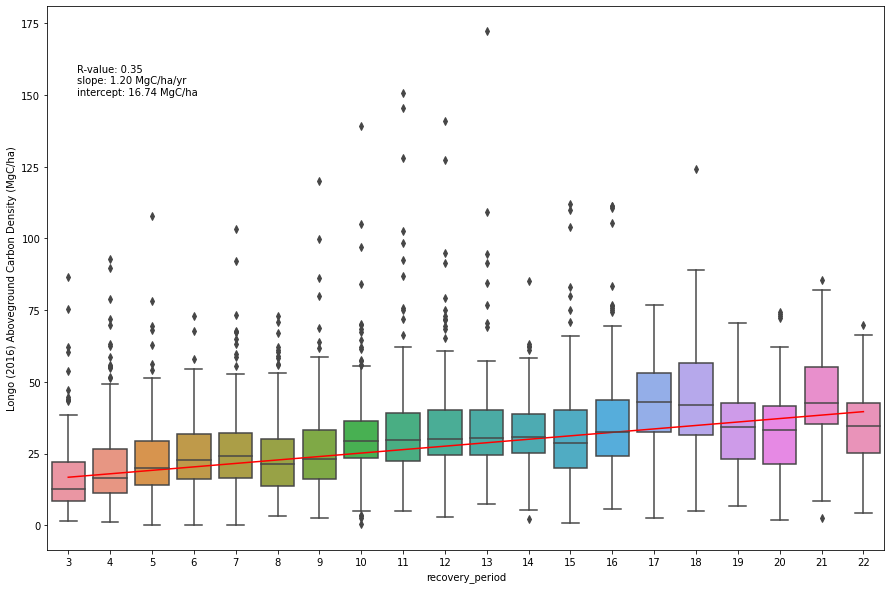

In [11]:
plt.figure(2, (15,10))
ax = sns.boxplot(x="recovery_period", y="acd_longo2016", data=quality_eba)
ax.set_ylabel("Longo (2016) Aboveground Carbon Density (MgC/ha)")
xs = range(0, 20)
ax.plot(xs, lin_acd_longo2016.intercept + lin_acd_longo2016.slope * xs, 'r')
text_label = (
    "R-score: {0:.2f}\n"
    "slope: {1:.2f} MgC/ha/yr\n"
    "intercept: {2:.2f} MgC/ha").format(
        lin_acd_longo2016.rvalue, lin_acd_longo2016.slope, lin_acd_longo2016.intercept)
ax.text(x=0.2, y=150, s=text_label)